### Ordinary least squares Linear Regression. LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2400 non-null   int64  
 1   bed             2400 non-null   float64
 2   bath            2400 non-null   float64
 3   acre_lot        2400 non-null   float64
 4   zip_code        2400 non-null   float64
 5   house_size      2400 non-null   float64
 6   prev_sold_date  2400 non-null   object 
 7   price           2400 non-null   float64
 8   prev_sold_year  2400 non-null   int64  
 9   zip_code_str    2400 non-null   int64  
 10  latitude        2400 non-null   float64
 11  longitude       2400 non-null   float64
 12  county          2400 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 243.9+ KB


#### Find the zip code of that has the most houses.

In [4]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

6010.0

#### Find the rows of the zip code that has the most houses.

In [5]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [6]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 227 to 267
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    41 non-null     int64  
 1   bed             41 non-null     float64
 2   bath            41 non-null     float64
 3   acre_lot        41 non-null     float64
 4   zip_code        41 non-null     float64
 5   house_size      41 non-null     float64
 6   prev_sold_date  41 non-null     object 
 7   price           41 non-null     float64
 8   prev_sold_year  41 non-null     int64  
 9   zip_code_str    41 non-null     int64  
 10  latitude        41 non-null     float64
 11  longitude       41 non-null     float64
 12  county          41 non-null     int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 4.5+ KB


#### Create an object to pass to the function that will normalize the data

In [7]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","zip_code","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
#normalize_df = one_zipcode_df
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,zip_code,latitude,longitude
263,-1.124451,-0.496015,-0.664627,-1.090172,-1.005250,2016,6010.0,41.681578,-72.940749
264,1.436799,0.700256,-0.868745,1.288049,0.154423,2020,6010.0,41.681578,-72.940749
265,0.583049,0.700256,0.304932,-1.109462,0.474425,2016,6010.0,41.681578,-72.940749
266,-0.270701,-0.496015,0.253902,-0.919315,0.162445,2022,6010.0,41.681578,-72.940749
267,-0.270701,-0.496015,-1.123892,-0.944117,-0.951768,2019,6010.0,41.681578,-72.940749


#### Create a variable for the correlation of the normalized data

In [8]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.625789
bed               0.299478
bath              0.556809
house_size        0.736449
prev_sold_year   -0.076401
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

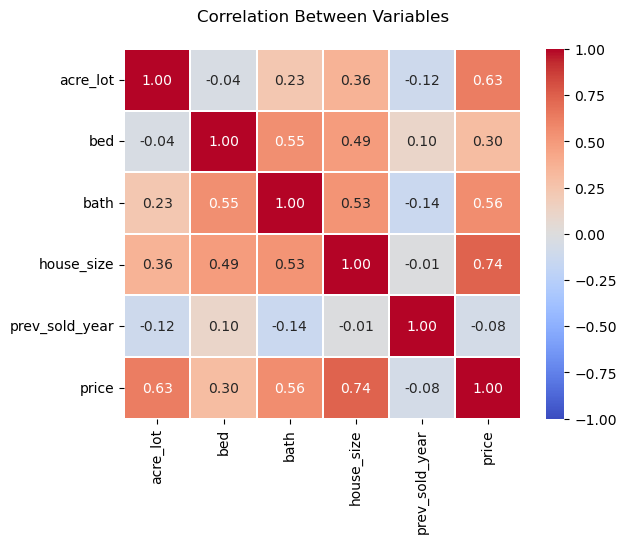

In [9]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [10]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [11]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [12]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [13]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [14]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Use Grid Search CV to find the best Hyperparameters for Linear Regression

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
linear_bp = dosomething("linear","Best Params", normalize_df, features, "price")
results_dict_append(linear_bp["results"])
linear_bp_predict = linear_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bed', 'bath', 'house_size']
Best Params EVS = 0.690220941
Best Params MSE = 0.687797
Best Params MAE = 0.627913
Best Params R2 = 0.684929
Best Params Fit Time = 0.002525138854980469


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [16]:
linear_sfm = dosomething("linear","Select From Model", normalize_df, features, "price")
results_dict_append(linear_sfm["results"])
linear_sfm_predict = linear_sfm["predictions"]

The selected features are: ['acre_lot', 'bath', 'house_size']
Select From Model EVS = 0.685384210
Select From Model MSE = 0.701177
Select From Model MAE = 0.617829
Select From Model R2 = 0.678800
Select From Model Fit Time = 0.0


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
linear_sfs = dosomething("linear","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(linear_sfs["results"])
linear_sfs_predict = linear_sfs["predictions"]

The selected features are: ['latitude', 'longitude', 'acre_lot', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.685384244
Sequential Feature Selector MSE = 0.701177
Sequential Feature Selector MAE = 0.617829
Sequential Feature Selector R2 = 0.678800
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [18]:
linear_rfe = dosomething("linear","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(linear_rfe["results"])
linear_rfe_predict = linear_rfe["predictions"]

The selected features are: ['longitude', 'acre_lot', 'bed', 'bath', 'house_size']
Recursive Feature Elimination EVS = 0.690220952
Recursive Feature Elimination MSE = 0.687796
Recursive Feature Elimination MAE = 0.627913
Recursive Feature Elimination R2 = 0.684929
Recursive Feature Elimination Fit Time = 0.001103353500366211


### Use Grid Search CV to find the best Parameters for Polynomial Regression

In [19]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [20]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('poly_model', LinearRegression())]),
             param_grid={'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False],
                         'poly_model__fit_intercept': [True]},
             verbose=1)

In [21]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'poly_features__degree': 1, 'poly_features__include_bias': False, 'poly_model__fit_intercept': True}


In [22]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])
pipeline_params

{'poly_features__degree': [1],
 'poly_features__include_bias': [False],
 'poly_model__fit_intercept': [True]}

In [23]:
poly_bp = dosomething("linear","PolynomialFeatures", normalize_df, features, "price", pipeline_params)
results_dict_append(poly_bp["results"])
poly_predict = poly_bp["predictions"]

PolynomialFeatures EVS = 0.690220951
PolynomialFeatures MSE = 0.687796
PolynomialFeatures MAE = 0.627913
PolynomialFeatures R2 = 0.684929
PolynomialFeatures Fit Time = 0.0033658027648925783


#### Graphing the results works best when the data is provided in a DataFrame.

In [24]:
poly_predict_df = pd.DataFrame(poly_predict).reset_index()
poly_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_bp_predict = pd.DataFrame(linear_bp_predict).reset_index()
linear_bp_predict.rename(columns={0: "prediction"},inplace=True)

linear_sfm_predict_df = pd.DataFrame(linear_sfm_predict).reset_index()
linear_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_sfs_predict_df = pd.DataFrame(linear_sfs_predict).reset_index()
linear_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_rfe_predict_df = pd.DataFrame(linear_rfe_predict).reset_index()
linear_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

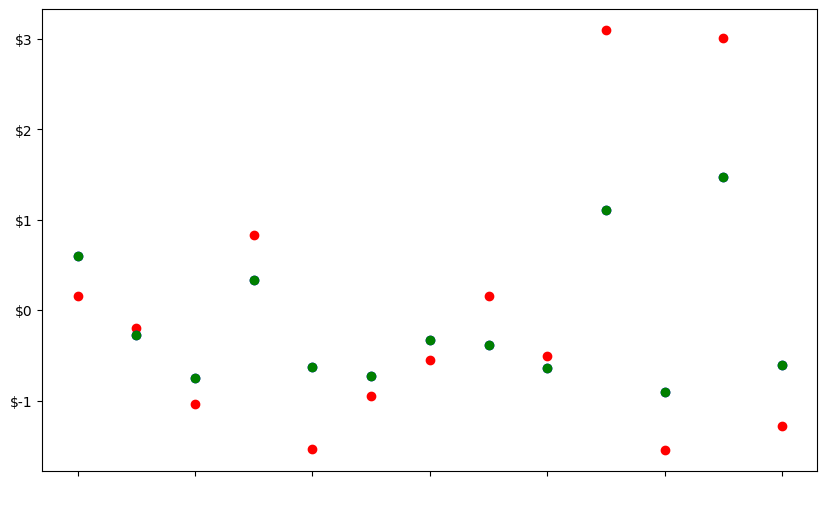

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="green")
plt.show()

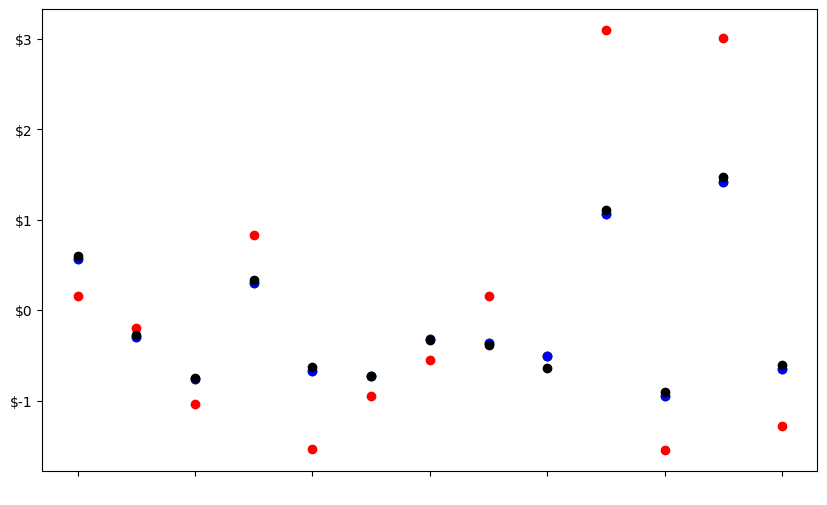

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(linear_sfs_predict_df.index,linear_sfs_predict_df["prediction"], color="green")
plt.scatter(linear_sfm_predict_df.index,linear_sfm_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [27]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination',
  'PolynomialFeatures'],
 'explained variance score': ['0.690220941',
  '0.685384210',
  '0.685384244',
  '0.690220952',
  '0.690220951'],
 'mae score': ['0.627913', '0.617829', '0.617829', '0.627913', '0.627913'],
 'mse score': ['0.687797', '0.701177', '0.701177', '0.687796', '0.687796'],
 'r2 score': ['0.684929', '0.678800', '0.678800', '0.684929', '0.684929'],
 'mean fit time': [0.002525138854980469,
  0.0,
  0.0,
  0.001103353500366211,
  0.0033658027648925783]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.690220941,0.627913,0.687797,0.684929,0.002525
Select From Model,0.685384210,0.617829,0.701177,0.678800,0.000000
Sequential Feature Selector,0.685384244,0.617829,0.701177,0.678800,0.000000
Recursive Feature Elimination,0.690220952,0.627913,0.687796,0.684929,0.001103
PolynomialFeatures,0.690220951,0.627913,0.687796,0.684929,0.003366
